# Prerequisite

Execute the following bash commands:
```bash
python -m venv .venv
source .venv/bin/activate

pip install skore==0.9.2
pip install skrub ipykernel ipywidgets seaborn nbformat
```

---

<picture>
    <source srcset="https://media.githubusercontent.com/media/probabl-ai/skore/main/sphinx/_static/images/Logo_Skore_Dark@2x.svg" media="(prefers-color-scheme: dark)">
    <img width="200" src="https://media.githubusercontent.com/media/probabl-ai/skore/main/sphinx/_static/images/Logo_Skore_Light@2x.svg" alt="skore logo">
</picture>

# Skore v0.9.2 demo

Links:
- skore: [GitHub repository](https://github.com/probabl-ai/skore), [documentation](https://skore.probabl.ai/), [demo videos](https://youtube.com/playlist?list=PLSIzlWDI17bTpixfFkooxLpbz4DNQcam3)
- skrub: [GitHub repository](https://github.com/skrub-data/skrub), [documentation](https://skrub-data.org/stable/)
- [Get to know Probabl](https://probabl.notion.site/Get-to-know-Probabl-127ef76d36b9804d8ca8e264e42f0cee)
- Contact: [Sylvain Combettes](https://www.linkedin.com/in/sylvain-combettes/) at `sylvain@probabl.ai`

First of all, check the version of skore and relevant libraries

In [1]:
!pip freeze | grep -E "skore|skrub|scikit-learn"

scikit-learn==1.6.1
skore==0.9.2
skore-local-project==0.0.3
skrub==0.5.3


# End-to-end machine learning with one-liners

## Data loading and exploration

Let us load the California housing dataset about predicting house prices (regression task) and perform some exploratory data analysis (EDA) on it:

In [2]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from skrub import TableReport

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X_y = pd.concat([X, y], axis=1)

TableReport(X_y)

Processing column   9 / 9


,,,,,,,,,


- We just imported skrub which is another open source and free package by the scikit-learn team. They have implemented it outside of scikit-learn for maintenance reasons and speed of releases. It started in 2018 (before Probabl was launched) and has a lot of momentum. Check out our list of open-source libraries at https://probabl.ai/labs.
- A great feature from skrub is its `TableReport`:
    - Contrary to the ydata-profiling library, `pip install skrub` should always work because it has very low number of dependencies and the interactive `TableReport` is implemented from scratch.
    - *Stats* tab: we observe that we have only numerical features and no missing values.
    - *Distributions* tab: we notice some outliers.
    - *Associations* tab: the associations can be interpreted same as correlations, but it also works with categorical features.

We split our data:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Modelling

We define our first estimator:

In [4]:
from skrub import tabular_learner

model_1 = tabular_learner("regressor")
model_1

Pipeline(steps=[('tablevectorizer',
                 TableVectorizer(high_cardinality=MinHashEncoder(),
                                 low_cardinality=ToCategorical())),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor())])

- The `tabular_learner` is another great feature from skrub: it automatically generates a big scikit-learn pipeline with some preprocessing then a `HistGradientBoostingRegressor` estimator:
    - This is not auto-ML, this is hard-coded human intelligence: for example, if we detect a datetime feature, then we extract the year, month, etc from it. 
    - You can of course customize this pipeline further.
    - This provides a baseline, a strong baseline!

## Model evaluation and inspection

Now, let us evaluate and inspect our model using a feature from skore:

In [5]:
from skore import EstimatorReport

model_report_1 = EstimatorReport(
    model_1,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)

skore has an `EstimatorReport`: you feed it your scikit-learn pipeline and the data, and you get some a lot of insights on your model:

In [6]:
model_report_1.help()

╭───────────── Tools to diagnose estimator HistGradientBoostingRegressor ──────────────╮
│ EstimatorReport                                                                      │
│ ├── .metrics                                                                         │
│ │   ├── .prediction_error(...)         - Plot the prediction error of a regression   │
│ │   │   model.                                                                       │
│ │   ├── .r2(...)               (↗︎)     - Compute the R² score.                       │
│ │   ├── .rmse(...)             (↘︎)     - Compute the root mean squared error.        │
│ │   ├── .timings(...)                  - Get all measured processing times related   │
│ │   │   to the estimator.                                                            │
│ │   ├── .custom_metric(...)            - Compute a custom metric.                    │
│ │   └── .summarize(...)                - Report a set of metrics for our estimator.  │
│ ├── .feature_importance                                                              │
│ │   └── .permutation(...)              - Report the permutation feature importance.  │
│ ├── .cache_predictions(...)            - Cache estimator's predictions.              │
│ ├── .clear_cache(...)                  - Clear the cache.                            │
│ ├── .get_predictions(...)              - Get estimator's predictions.                │
│ └── Attributes                                                                       │
│     ├── .X_test                        - Testing data                                │
│     ├── .X_train                       - Training data                               │
│     ├── .y_test                        - Testing target                              │
│     ├── .y_train                       - Training target                             │
│     ├── .estimator                     - Estimator to make the report from           │
│     ├── .estimator_                    - The cloned or copied estimator              │
│     ├── .estimator_name_               - The name of the estimator                   │
│     ├── .fit                           - Whether to fit the estimator on the         │
│     │   training data                                                                │
│     ├── .fit_time_                     - The time taken to fit the estimator, in     │
│     │   seconds                                                                      │
│     ├── .ml_task                       - No description available                    │
│     └── .pos_label                     - For binary classification, the positive     │
│         class                                                                        │
│                                                                                      │
│                                                                                      │
│ Legend:                                                                              │
│ (↗︎) higher is better (↘︎) lower is better                                             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

You can evaluate your model using the `metrics` accessor:

In [7]:
report_metrics_1 = model_report_1.metrics.summarize().frame()
report_metrics_1

,HistGradientBoostingRegressor
Metric,
R²,0.833332
RMSE,0.469372
Fit time (s),0.903935
Predict time (s),0.018965


You can also add your custom scores to the above report on metrics (if you have used scikit-learn's `make_scorer`).

You can also perform some inspection using the `feature_importance` accessor, for example the permutation feature importance:

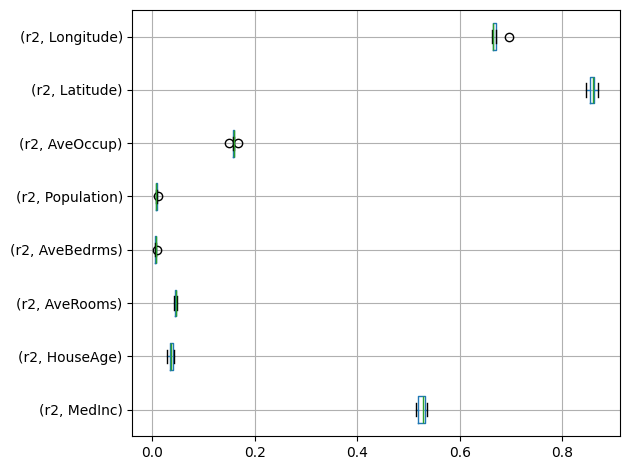

In [9]:
import matplotlib.pyplot as plt

model_report_1.feature_importance.permutation(data_source="test").T.boxplot(vert=False)
plt.tight_layout()

- The `EstimatorReport` works for all scikit-learn compatible estimators or pipelines (have `.fit()` and `.transform()` or `.predict()`), including deep learning with
    - `skorch`: this is pytorch but with `.fit()` and `.predict()`
    - `keras`: directly compatible

And... that's it!
- in one line, you have the EDA with `skrub.TableReport`
- in one line, you create a pipeline with `skrub.tabular_learner`
- in one line, you evaluated and inspected your model with `skore.EstimatorReport`

We have helped you achieve an end-to-end machine learning workflow with 3 one-liners! This is the vision of data science we have at Probabl, helping you get started and avoid white sheet anxiety. Then, based on these insights, you can iterate and refine.

# Creating a skore project

Apart from the ML methological aspects, skore can also help you perform some experiment tracking.
The skore `Project` helps you store all kinds of objects.

Let us create a skore project:

In [ ]:
from skore import Project

my_project = Project("my_project")
#my_project.delete("my_project")

- You have a folder in your directory: it was just created.
    - It exists even when you close this notebook.

`put` does the storing:

In [11]:
my_project.put("model_report", model_report_1)

You can get your previously stored object:

In [12]:
summary = my_project.summarize()
print(type(summary))

<class 'skore.project.summary.Summary'>


In [13]:
from pprint import pprint

reports_get = summary.reports()
pprint(reports_get)

[EstimatorReport(estimator=Pipeline(steps=[('tablevectorizer',
                 TableVectorizer(high_cardinality=MinHashEncoder(),
                                 low_cardinality=ToCategorical())),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor())]), ...),
 EstimatorReport(estimator=Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), ...),
 EstimatorReport(estimator=Pipeline(steps=[('tablevectorizer',
                 TableVectorizer(high_cardinality=MinHashEncoder(),
                                 low_cardinality=ToCategorical())),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor())]), ...)]


# Trying out another model

Now, after the `tabular_learner` model, let us create a second one, a simple Ridge regressor with some scaling:

In [14]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model_2 = make_pipeline(StandardScaler(), Ridge())

model_report_2 = EstimatorReport(
    model_2,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
report_metrics_2 = model_report_2.metrics.summarize().frame()
report_metrics_2

,Ridge
Metric,
R²,0.591163
RMSE,0.735134
Fit time (s),0.008853
Predict time (s),0.000685


I use the exact same `report_metrics` key to store this second model, and we will see that nothing is overwritten:

In [15]:
my_project.put("model_report", model_report_2)

I can retrieve everything I previously stored, nothing is lost (unless you explicitely delete something):

In [16]:
reports_get = my_project.summarize().reports()
pprint(reports_get)

[EstimatorReport(estimator=Pipeline(steps=[('tablevectorizer',
                 TableVectorizer(high_cardinality=MinHashEncoder(),
                                 low_cardinality=ToCategorical())),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor())]), ...),
 EstimatorReport(estimator=Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), ...),
 EstimatorReport(estimator=Pipeline(steps=[('tablevectorizer',
                 TableVectorizer(high_cardinality=MinHashEncoder(),
                                 low_cardinality=ToCategorical())),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor())]), ...),
 EstimatorReport(estimator=Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), ...)]


For example, let us load the last estimator report and retrieve the testing data from it:

In [17]:
report_load = reports_get[0]
report_load.estimator_.predict(report_load.X_test)

array([1.43368259, 2.68399363, 1.44117411, ..., 1.9907086 , 1.9669089 ,
       2.5965567 ], shape=(5160,))

Furthermore, we can easily benchmark estimators using the `ComparisonReport`:

In [18]:
from skore import ComparisonReport

comparator = ComparisonReport(reports=reports_get)
comparator.metrics.summarize().frame()

Output()

Estimator,HistGradientBoostingRegressor_1,Ridge_1,HistGradientBoostingRegressor_2,Ridge_2
Metric,,,,
R²,0.831435,0.591163,0.833332,0.591163
RMSE,0.472036,0.735134,0.469372,0.735134
Fit time (s),0.438812,0.002593,0.903935,0.008853
Predict time (s),0.039756,0.000818,0.016697,0.000652


# Search

In [19]:
summary = my_project.summarize()
summary.reports()

[EstimatorReport(estimator=Pipeline(steps=[('tablevectorizer',
                  TableVectorizer(high_cardinality=MinHashEncoder(),
                                  low_cardinality=ToCategorical())),
                 ('histgradientboostingregressor',
                  HistGradientBoostingRegressor())]), ...),
 EstimatorReport(estimator=Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), ...),
 EstimatorReport(estimator=Pipeline(steps=[('tablevectorizer',
                  TableVectorizer(high_cardinality=MinHashEncoder(),
                                  low_cardinality=ToCategorical())),
                 ('histgradientboostingregressor',
                  HistGradientBoostingRegressor())]), ...),
 EstimatorReport(estimator=Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), ...)]

In [20]:
summary

run_id  \
  id                                                                   
0 5ce5e04e5c3f70ebc238b7efd961160c  e1119007921a4cfd8e4ac62f3a14c45a   
1 fe9eb18a0ea7d986972b22bad63b9db1  e1119007921a4cfd8e4ac62f3a14c45a   
2 5e47c25d535357aca4b5a68bcf42fded  b7be85396f4a481ca75fefb0218061f0   
3 f651888f9cb66ff74e4d9dc98e170ebe  b7be85396f4a481ca75fefb0218061f0   

                                             key  \
  id                                               
0 5ce5e04e5c3f70ebc238b7efd961160c  model_report   
1 fe9eb18a0ea7d986972b22bad63b9db1  model_report   
2 5e47c25d535357aca4b5a68bcf42fded  model_report   
3 f651888f9cb66ff74e4d9dc98e170ebe  model_report   

                                                                date  \
  id                                                                   
0 5ce5e04e5c3f70ebc238b7efd961160c  2025-07-08T11:42:49.877132+00:00   
1 fe9eb18a0ea7d986972b22bad63b9db1  2025-07-08T11:42:49.941570+00:00   
2 5e47c25d535357aca4b5a68bcf42fded  2025-07-08T13:16:15.207269+00:00   
3 f651888f9cb66ff74e4d9dc98e170ebe  2025-07-08T13:16:15.299361+00:00   

                                                          learner  \
  id                                                                
0 5ce5e04e5c3f70ebc238b7efd961160c  HistGradientBoostingRegressor   
1 fe9eb18a0ea7d986972b22bad63b9db1                          Ridge   
2 5e47c25d535357aca4b5a68bcf42fded  HistGradientBoostingRegressor   
3 f651888f9cb66ff74e4d9dc98e170ebe                          Ridge   

                                                             dataset  \
  id                                                                   
0 5ce5e04e5c3f70ebc238b7efd961160c  85472753a486aaff2631983499cce8b3   
1 fe9eb18a0ea7d986972b22bad63b9db1  85472753a486aaff2631983499cce8b3   
2 5e47c25d535357aca4b5a68bcf42fded  85472753a486aaff2631983499cce8b3   
3 f651888f9cb66ff74e4d9dc98e170ebe  85472753a486aaff2631983499cce8b3   

                                       ml_task      rmse log_loss roc_auc  \
  id                                                                        
0 5ce5e04e5c3f70ebc238b7efd961160c  regression  0.472036     None    None   
1 fe9eb18a0ea7d986972b22bad63b9db1  regression  0.735134     None    None   
2 5e47c25d535357aca4b5a68bcf42fded  regression  0.469372     None    None   
3 f651888f9cb66ff74e4d9dc98e170ebe  regression  0.735134     None    None   

                                    fit_time  predict_time  
  id                                                        
0 5ce5e04e5c3f70ebc238b7efd961160c  0.438812      0.014253  
1 fe9eb18a0ea7d986972b22bad63b9db1  0.002593      0.000451  
2 5e47c25d535357aca4b5a68bcf42fded  0.903935      0.018965  
3 f651888f9cb66ff74e4d9dc98e170ebe  0.008853      0.000685

In [21]:
summary.reports()

[EstimatorReport(estimator=Pipeline(steps=[('tablevectorizer',
                  TableVectorizer(high_cardinality=MinHashEncoder(),
                                  low_cardinality=ToCategorical())),
                 ('histgradientboostingregressor',
                  HistGradientBoostingRegressor())]), ...),
 EstimatorReport(estimator=Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), ...),
 EstimatorReport(estimator=Pipeline(steps=[('tablevectorizer',
                  TableVectorizer(high_cardinality=MinHashEncoder(),
                                  low_cardinality=ToCategorical())),
                 ('histgradientboostingregressor',
                  HistGradientBoostingRegressor())]), ...),
 EstimatorReport(estimator=Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), ...)]